# INF8775 – Analyse et conception d’algorithmes
# TP2 – Automne 2025

Perron Touchette, Thomas, 2201589

Benouhoud, Mehdi, 2188585

Note finale :

 <u>**Date limite de remise :**</u>  11 novembre 23h59 (Groupe B1), 4 novembre 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.  Cela s'applique aussi au niveau de l'IA générative pour le code. Par contre, vous devez être capable d'accomplir les analyses par vous-même. Vous ne pouvez pas utiliser l'IA pour ces sections.
## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition.

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [1]:
!pip install numpy matplotlib scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time
from collections.abc import Callable

In [3]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.
    """
    # Create a figure and axis
    _, ax = plt.subplots()

    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')

    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)

    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)

    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes, nbSamples=5):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(nbSamples)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    N = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [20]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

partition = readFile('Chansons/twinkle_twinkle.txt')

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [ ]:
class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, mean: int, score: int) -> None:
        self.size = size
        self.mean_score = score
        self.mean = mean

def is_valid_solution(original: list[int], solution: list[int]) -> bool:
    """Validates solution"""

    n = len(original)

    if len(solution)!=n:
      return False

    for i in range(n):
        if solution[i]<0 or solution[i]>=D:
            return False

    # Solution is valid
    return True

def measure(procedure: Callable, sample: list[int], costs,  time_scale: int) -> int:
    """Returns the time in milliseconds taken to run the procedure.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    score = getTotalCost(costs, sample, solution)
    return (round(end - start), score)

def measure_mean(procedure: Callable, samples: list[list[int]], size: int, costs, time_scale: int) -> Measure:
    """Generates multiple samples with the specified parameters and returns the mean time in milliseconds

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    results=[measure(procedure, sample, costs, time_scale) for sample in samples]
    mean_time = sum(
        [result[0] for result in results]
    ) / size
    mean_score = sum(
        [result[1] for result in results]
    ) / size
    return Measure(size, mean_time, mean_score)

def measure_procedure(procedure: Callable, dataset: list[list[list[int]]], costs,  time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken in milliseconds for each size in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time.
    """
    return [
        measure_mean(procedure, samples, size, costs, time_scale)
        for size, samples in dataset.items()
    ]


def display_measures_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <16} {: <16} {: <16}".format("Taille", "Temps moyen", "Score moyen"))
    for measure in measures:
        print("{: <16} {: <16} {: <16}".format(measure.size, measure.mean, measure.mean_score))

def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton (6 points)

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

Coût Glouton : 143


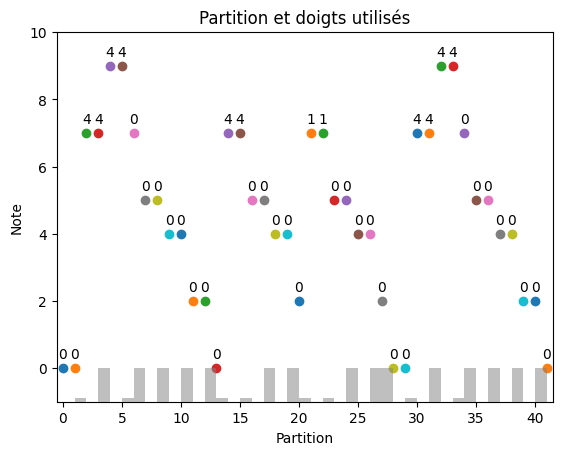

La solution gloutonne est valide.


In [27]:
def greedy_choice(current_note: int, next_note: int, previous_finger: int, nb_available_fingers: int) -> int:
    lowest_cost = float('inf')
    current_best_finger = 0

    for finger in range(nb_available_fingers):
        cost = getCosts(costs, [current_note, next_note], [previous_finger, finger])[0]
        if cost < lowest_cost:
            lowest_cost = cost
            current_best_finger = finger

    return current_best_finger
                  
def glouton(partition):
    partition_length = len(partition)
    if partition_length == 0: return []

    solution = [0 for _ in range(partition_length)]

    lowest_cost = float('inf')
    best_first_finger, best_second_finger = 0, 0

    for first_finger in range(D):
        for second_finger in range(D):
            cost = getCosts(costs, partition[:2], [first_finger, second_finger])[0]
            if cost < lowest_cost:
                lowest_cost = cost
                best_first_finger, best_second_finger = first_finger, second_finger

    solution[0], solution[1] = best_first_finger, best_second_finger

    for i in range(2, partition_length):
        solution[i] = greedy_choice(partition[i-1], partition[i], solution[i-1], D)

    return solution

solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

if is_valid_solution(partition, solutionGlouton):
    print("La solution gloutonne est valide.")
else:
    print("La solution gloutonne n'est pas valide.")

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [46]:
matricule = 2188585
dataset = get_dataset(seed=matricule, sizes=[510_000, 20_000, 25_000, 50_000, 100_000, 200_000, 250_000, 500_000, 1_000_000, 2_500_000])
measures_glouton = measure_procedure(glouton, dataset, costs)
display_measures_table(measures_glouton)

Taille           Temps moyen      Score moyen     
510000           0.12011764705882352 74.39195882352941
20000            0.1277           74.2967         
25000            0.13264          74.87548        
50000            0.128            74.18498        
100000           0.12542          74.77019        
200000           0.121605         74.70661        
250000           0.12464          74.517384       
500000           0.12649          74.441802       
1000000          0.125211         74.553583       
2500000          0.1273776        74.4375532      


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

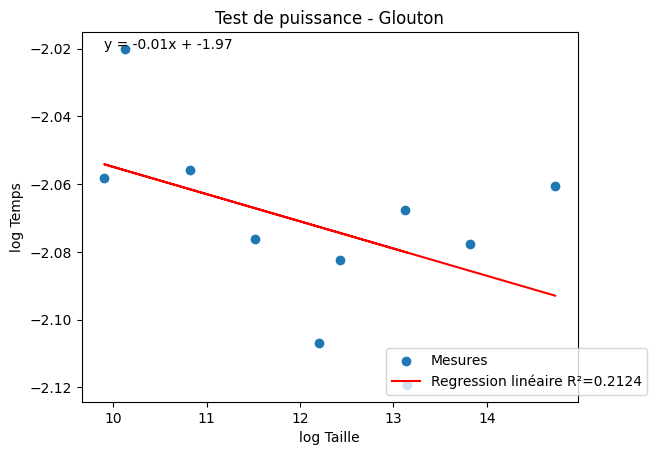

In [48]:
import math
def values_test_puissance(measures):
    return {
        math.log(measure.size): math.log(measure.mean)
        for measure in measures
    }
display_test_puissance(values_test_puissance(measures_glouton), title="Test de puissance - Glouton")

*Insérer votre réponse ici*

## Partie 2 : Algorithme de programmation dynamique (6 points)

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

In [ ]:
def progDyn(partition):
    solution = [0 for i in range(len(partition))]
    return solution

solutionDyn = progDyn(partition)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

*Insérer votre réponse ici*

## Partie 3 : Algorithme de recherche locale (6 points)

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

In [ ]:
def localSearch(partition):
    solution = [0 for i in range(len(partition))]
    return solution

solutionLocal = localSearch(partition)
print("Coût Recherche Locale :", getTotalCost(costs, partition, solutionLocal))
visualize_solution(costs, partition, solutionLocal)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

*Insérer votre réponse ici*

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

*Insérer votre réponse ici*

# Évaluation de la consommation énergétique (1 point)

Dans le cadre de ce TP, nous voulons vous sensibiliser à la consommation énergétique de vos algorithmes. Pour ce faire, nous vous fournissons une librairie que vous pouvez utiliser pour évaluer l'énergie nécessaire à la complétion de votre algorithme (https://mlco2.github.io/codecarbon/). Appelez chacun de vos algorithmes ci-bas avec les mêmes exemplaires et comparez le résultat obtenu par chacun.

In [ ]:
#Commande pour installer la librairie
#!pip install codecarbon

from codecarbon import EmissionsTracker
try:
    tracker = EmissionsTracker(measure_power_secs=5, tracking_mode="process")

    tracker.start_task("glouton")
    # TODO Appel glouton
    tracker.stop_task()

    tracker.start_task("dynamic")
    # TODO Appel dynamique
    tracker.stop_task()

    tracker.start_task("recherche")
    # TODO Appel recherche
    tracker.stop_task()
finally:
    _ = tracker.stop()

Les résultats de l'exécution du code ci-haut devraient apparaître dans un fichier csv. Commentez les résultats obtenus. Vous pouvez trouver une explication de la sortie dans la documentation qui est présente au lien ci-haut.

*Insérer votre réponse ici*

# Conclusion et synthèse (2 points)

Résumez succintement vos résultats et analyses, en mettant en évidences les forces et faiblesses de chacun des algorithmes. Indiquez sous quelles conditions vous utiliseriez chacun d'eux.

*Insérer votre réponse ici*